# Introduction

This notebook will look into long-term unemployment through a small analysis. First the data is found on Statistics Denmark, accessed by an API, cleaned and structured and afterwards analyzed briefly.
First we import the packages that will be used in this notebook:

In [1]:
# import relevant packages
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import ipywidgets as widgets
import pandas as pd
import pydst
dst = pydst.Dst(lang = 'en')

# Find data on Statistics Denmark

Statistics Denmark contains a lot of tables. Therefore it was easier to go to [statisikbanken.dk (bank of statistics)](http://statistikbanken.dk/statbank5a/default.asp?w=1366) and surf around to find some interesting tables. We ended up with the table **AULK10** that contains unemployment after duration and age. In this notebook we will focus on long-term unemployment which is specied later in the code.

Now we have considered what table to look at, we need some lines of code to decide what variables we are interested in.

In [2]:
# see the name of the variables
aulk10 = dst.get_variables(table_id = 'AULK10')
print(aulk10)

# explore the values for 'type of benefits' further to pick only one of them
aulk10.loc[1]['values']

   elimination           id              text   time  \
0        False         KMDR          duration  False   
1        False        ENHED              unit  False   
2         True  YDELSESTYPE  type of benefits  False   
3         True        ALDER               age  False   
4        False          Tid              time   True   

                                              values  
0  [{'id': '026', 'text': '26 weeks'}, {'id': '03...  
1  [{'id': '1', 'text': 'Persons (number)'}, {'id...  
2  [{'id': 'TOT', 'text': 'Total'}, {'id': '01', ...  
3  [{'id': 'TOT', 'text': 'Age, total'}, {'id': '...  
4  [{'id': '2008M07', 'text': '2008M07'}, {'id': ...  


[{'id': '1', 'text': 'Persons (number)'},
 {'id': '4', 'text': 'Persons in pct. of gross unemployed'},
 {'id': '5', 'text': 'Persons per 1,000 in the labour force'}]

The table consists of 5 variables: duration, unit, type of benefits, age and time. We choose to explore duration (grouped), age (grouped) and time. Because we don't want to explore different types of benefits we looked into the values for that variable and will in the next lines of code choose id=1: **persons (number).**

In [3]:
# get the data from dst via an API and save it as 'unemp' 
unemp = dst.get_data(table_id = 'AULK10', variables = {'KMDR': ['*'], 'ENHED': ['1'], 'ALDER': ['*'], 'TID': ['*']})

# see a snip of the data
print(unemp.head(10))

# see the shape of the data
print(f'unemp has shape {unemp.shape}')

        KMDR             ENHED        ALDER      TID YDELSESTYPE  INDHOLD
0  104 weeks  Persons (number)   Age, total  2013M03       Total   9261.0
1  130 weeks  Persons (number)   Age, total  2013M03       Total   5624.0
2  156 weeks  Persons (number)   Age, total  2013M03       Total   3332.0
3   26 weeks  Persons (number)  16-29 years  2013M04       Total  14280.0
4   39 weeks  Persons (number)  16-29 years  2013M04       Total   8414.0
5   52 weeks  Persons (number)  16-29 years  2013M04       Total   4962.0
6   78 weeks  Persons (number)  16-29 years  2013M04       Total   1990.0
7  104 weeks  Persons (number)  16-29 years  2013M04       Total    754.0
8  130 weeks  Persons (number)  16-29 years  2013M04       Total    403.0
9  156 weeks  Persons (number)  16-29 years  2013M04       Total    195.0
unemp has shape (3416, 6)


# Cleaning and structuring of data

The dataset needs to be cleaned and restructured before we can do analysis on it. First we dopt the columns that are the same for all observations. After each cleaning step we look at a snip and the shape of the dataset to see what happened.

In [4]:
# drop the columns 'enhed' and 'ydelsestype' as they are the same for all observations
unemp.drop(['ENHED','YDELSESTYPE'], axis = 1, inplace = True)

# status after this
print(unemp.head(10))
print(f'unemp has shape {unemp.shape}')

        KMDR        ALDER      TID  INDHOLD
0  104 weeks   Age, total  2013M03   9261.0
1  130 weeks   Age, total  2013M03   5624.0
2  156 weeks   Age, total  2013M03   3332.0
3   26 weeks  16-29 years  2013M04  14280.0
4   39 weeks  16-29 years  2013M04   8414.0
5   52 weeks  16-29 years  2013M04   4962.0
6   78 weeks  16-29 years  2013M04   1990.0
7  104 weeks  16-29 years  2013M04    754.0
8  130 weeks  16-29 years  2013M04    403.0
9  156 weeks  16-29 years  2013M04    195.0
unemp has shape (3416, 4)


This step left the number of rows unchanged but decreased the number of columns from 6 to 4. Now we want to change the names of the variables (columns).

In [5]:
# change the name of the columns by a dictionary
columns_dict = {}
columns_dict['KMDR'] = 'duration' # in weeks
columns_dict['ALDER'] = 'age' # age groups and total
columns_dict['TID'] = 'month'
columns_dict['INDHOLD'] = 'n_persons' # number of persons

unemp.rename(columns = columns_dict, inplace = True)
print(unemp.head(10))

    duration          age    month n_persons
0  104 weeks   Age, total  2013M03    9261.0
1  130 weeks   Age, total  2013M03    5624.0
2  156 weeks   Age, total  2013M03    3332.0
3   26 weeks  16-29 years  2013M04   14280.0
4   39 weeks  16-29 years  2013M04    8414.0
5   52 weeks  16-29 years  2013M04    4962.0
6   78 weeks  16-29 years  2013M04    1990.0
7  104 weeks  16-29 years  2013M04     754.0
8  130 weeks  16-29 years  2013M04     403.0
9  156 weeks  16-29 years  2013M04     195.0


The shape is unchanged and therefore not shown. Next up is to delete missings and change the datatypes. As the code below shows all of the variables are loaded as objects (strings) and we need to make them more appropriate to do the analyses and the last cleaning.
In this table Statistics Denmark named some observations '..' which is missings or too insecure to be shown. These are deleted.

In [6]:
# a. drop rows where n_persons='..' (missings)
unemp = unemp[unemp.n_persons != '..'] 

# b. see the initial dataypes
print(unemp.dtypes)

# c. change type of n_persons and duration to integers 
unemp.n_persons = unemp.n_persons.astype(str).str[:-2] # isolate to the whole number of persons (drop ',0')
unemp.n_persons = unemp.n_persons.astype(int) # convert n_persons to integer
unemp.duration = unemp.duration.astype(str).str[:-6] # isolate the actual duration (drop ' weeks') 
unemp.duration = unemp.duration.astype(int) # convert to an integer

# d. create date from month
unemp['d'] = (unemp.month.astype(str).str[:4] # grab the year (first four digits)
          + '/' # add /
          + unemp.month.astype(str).str[-2:]) # grab the month (last two digits)
unemp['date'] = pd.to_datetime(unemp.d, format = '%Y/%m')
unemp.drop(['month', 'd'], axis = 1, inplace = True) # drop month and intermediate variable, d 

# e. check new types and shape
print(unemp.dtypes)
print(unemp.head(5))
print(f'unemp has shape {unemp.shape}')

duration     object
age          object
month        object
n_persons    object
dtype: object
duration              int32
age                  object
n_persons             int32
date         datetime64[ns]
dtype: object
   duration          age  n_persons       date
0       104   Age, total       9261 2013-03-01
1       130   Age, total       5624 2013-03-01
2       156   Age, total       3332 2013-03-01
3        26  16-29 years      14280 2013-04-01
4        39  16-29 years       8414 2013-04-01
unemp has shape (3044, 4)


The cleaning of missing values reduces the number of rows. In the documentation of the table Statistic Denmark defines long-term unemployment as a duration of 52 weeks or more. We will only consider the long-term unemployment.

In [7]:
# restrict the dataset to duration >= 52
unemp = unemp.loc[unemp['duration'] >= 52]

# see a snippet and the shape of the data
print(unemp.head(5))
print(f'unemp has shape {unemp.shape}')

   duration          age  n_persons       date
0       104   Age, total       9261 2013-03-01
1       130   Age, total       5624 2013-03-01
2       156   Age, total       3332 2013-03-01
5        52  16-29 years       4962 2013-04-01
6        78  16-29 years       1990 2013-04-01
unemp has shape (2080, 4)


# Analysis

## Descriptive statics: Table and static figure with mean

Now the data is structured and cleaned and we can begin our brief analysis. First we group the data both after age and duration. The descriptive statistic is then the **variation over time in the number of persons for each age-group and duration-group.**

The count is the same for each duration which shows that we have the same number of month-observations for each duration across age-groups. Furthermore we see that each duration have different number of month-observations - this will affect one of the coming graphs.

When looking at the mean we see that the group of 30-49 old is the largest group of long-term unemployed persons and the 16-29 old are the smallest group for all durations. Notice that 'Age, total' is a sum of the 3 age-groups for each duration.

The difference in level make it hard to compare the different age groups. A solution to that problem is to calculate index and look at the development over the months.

In [8]:
# descriptive statics grouped by the age-groups and duration describes the data across time
desc = unemp.groupby(['age', 'duration']).describe()
pd.options.display.float_format = '{:.0f}'.format # shows only one decimal
print(desc)

                           n_persons                                         
                               count  mean  std   min   25%   50%   75%   max
age               duration                                                   
16-29 years       52             116  3787 1178  1315  2907  3771  4912  5701
                  78             110  1418  580   582   915  1306  1954  2615
                  104            104   525  317   128   242   424   790  1072
                  130             98   222  155    41    84   171   379   545
                  156             92    97   71    16    38    74   178   235
30-49 years       52             116 14315 4655  5554 10258 14464 18860 21956
                  78             110  7541 2696  3038  4948  7616  9878 12157
                  104            104  4129 1549  1900  2611  4266  5282  6708
                  130             98  2431  835  1128  1686  2468  3161  3965
                  156             92  1486  444   679  1096  147

But before we will compare the age-groups further we will dive more into the **mean number of persons of the 'Age, total'-group divded in different durations in Figure 1 below.**

Not surprising the higher duration the lower number of people are unemployed. From the graph (and the describtive table above) we see that the number of persons (on average across months) drops by more than 10,000 when looking at a duration of 78 weeks (1.5 year) relative to 52 weeks (1 year).

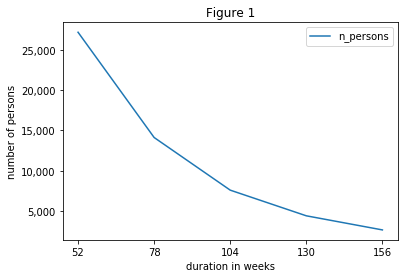

In [9]:
# a. figure with mean of each duration (across months) for total age
mean = unemp.groupby(['age', 'duration']).mean()
mean = mean.loc['Age, total'] # only look at total age

# b. plot for total age
def static_figure():
    
    # i. docstring
    """ Makes a static figure of the mean number of persons of the 'Age, total'-group.
    
    Args: None  
            
    """
    
    # ii. make the plot
    ax = mean['n_persons'].plot(legend = True)
    
    # iii. set thousands separator on y-axis
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    
    # iv. set x-axis to the number of weeks according to duration
    ax.set_xticks([52, 78, 104, 130, 156])
    
    # v. set labels
    ax.set_ylabel('number of persons')
    ax.set_xlabel('duration in weeks')
    
    # vi. set title
    ax.set_title('Figure 1')

# c. call the function
static_figure()


## Descriptive statics: Interactive figure with indices

Now we dive more into the comparison between the age-groups. This is done with indices which is calculated by 

\\[
\begin{eqnarray*}
index & = & \frac{value_t}{value_0}*100
\end{eqnarray*}\\]

where 0 defines the basis-month. Here we will use the first available month as basis.

In [10]:
# a. make copy
unemp2 = unemp.copy()

# b. sort
unemp2.sort_values(by = ['date', 'duration'], inplace = True)
unemp2.reset_index(inplace = True)
unemp2.drop(['index'], axis = 1, inplace = True) #delete the old index

# c. select the first element in a series
def first(x): 
    return x.iloc[0]

# d. group the data and calcualte the index
grouped = unemp2.groupby(['duration', 'age'])
unemp2['cal_index'] = grouped['n_persons'].transform(lambda x: x/first(x)*100)

# e. set index to the figure (run only once!)
unemp2.set_index('date', inplace = True)

# f. check the dataset
print(unemp2.head(10))

            duration                age  n_persons  cal_index
date                                                         
2009-01-01        52        16-29 years       1329        100
2009-01-01        52        30-49 years       5572        100
2009-01-01        52  50 years and over       3789        100
2009-01-01        52         Age, total      10690        100
2009-02-01        52        16-29 years       1315         99
2009-02-01        52        30-49 years       5554        100
2009-02-01        52  50 years and over       3731         98
2009-02-01        52         Age, total      10600         99
2009-03-01        52        16-29 years       1338        101
2009-03-01        52        30-49 years       5638        101


In the next lines of code we make an **interactive figure with the calculated indices over time where you can choose which duration you want to look at.**

In [11]:
# a. plot that is used to the interactive figure
def interactive_figure(x = 52):
    
    # i. docstring
    """ Makes an interactive figure of the calcualtes indices over time.
    
    Args: x : int
        Duration.
            
    """
    
    # ii. make the plot
    I = unemp2.duration == x # plots only if duration = x (argument)
    unemp2[I].groupby(['age'])['cal_index'].plot(legend = True) 
    
    # iii. set labels
    plt.xlabel('Year')
    start_index = unemp2.loc[(unemp2['cal_index'] == 100.0) & (unemp2['duration'] == x)].index # find the basis-month
    start_index2 = min(start_index) # as there is a month for each age-group we just select one of them (they are the same)
    plt.ylabel(f'Index (100 = {start_index2.date()})') # an interactive y-label that shows the basis-month
    
    # iv. set title
    plt.title('Figure 2')

# b. print values for duration to use in the dropdown
unemp2.duration.unique()

# c. dropdown with durations
widgets.interact(interactive_figure,
    x = widgets.Dropdown(description = '$duration$', options = [52, 78, 104, 130, 156])
)

interactive(children=(Dropdown(description='$duration$', options=(52, 78, 104, 130, 156), value=52), Output())…

<function __main__.interactive_figure(x=52)>

Figure 2 shows the development in long-term unemployment across age-groups and for different durations. It is seen e.g. for a duration of 104 weeks that the unemployment rises a lot from 2010-2012. From 2013 it starts to decrease and the group of 50+ years decreases fastest. Despite this the group of 16-29 year olds ends at the lowest level, even lower than the level in the basis-month. Notice that the basis-month is showed on the y-axis for each duration.